In [1]:
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, VectorField
from pde import FieldCollection, PDEBase, CartesianGrid
from scipy.stats import multivariate_normal

The fokker planck equation can be written as
$$
\begin{align}
    \frac{\partial p}{\partial t} = -\nabla \cdot (p({\bf x},t) \nu({\bf x})) + \frac{1}{2} \nabla \cdot \nabla (D p({\bf x}, t))
\end{align}
$$

In [2]:
class Lorenz63(PDEBase):
    
    def __init__(self, mobility, s=10, r=28, b=8/3 ,
                 sigma=0.8, bc='periodic'):
        super().__init__()
        self.s = s
        self.r = r
        self.b = b
        self.diffusivity = np.square(sigma)
        self.bc = bc
        self.mobility = mobility

    def evolution_rate(self, state, t=0):
        term1 = self.mobility * state
        term2 = self.diffusivity * state.gradient(self.bc)
        return -term1.divergence(self.bc) + 0.5 * term2.divergence(self.bc)

In [9]:
## Constants

# Grid extents
dims = 3
extents = [[-20, 20], [-20, 20], [0, 50]]
npoints = [80, 80, 100]

# PDE parameters
s = 10
r = 28
b = 8/3
sigma = 4/5
bc = {'value': 0}

# Initial PDF Configuration
mu = (-5.91652, -5.52332, 24.5723)
cov = np.ones(3)*10


In [10]:
def nu(x):
    nu1 = -s * (x[0] - x[1])
    nu2 = r * x[0] - x[1] - x[0] * x[2]
    nu3 = x[0] * x[1] - b * x[2]
    return np.stack([nu1, nu2, nu3])

In [11]:
# Initial PDF
x = [np.linspace(*extents[i], npoints[i]) for i in range(dims)]

mesh = np.meshgrid(*x, indexing='ij')
points = np.stack(mesh, axis=-1)

gaus_pdf = multivariate_normal(mean=mu, 
                               cov=cov).pdf

# Mesh grid
grid = CartesianGrid(extents, npoints)

# Initial scalar field
p0 = gaus_pdf(points)
field = ScalarField(grid, p0)

# Comput mobilitity constants for the grid
points = np.stack(mesh)
mobility = VectorField(grid, nu(points))

# Fokker-Planck PDE for Lorenz-63 system
eq = Lorenz63(s=s, r=r, b=b, sigma=sigma, bc=bc, mobility=mobility)

In [12]:
def scale(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min)/(x_max - x_min)

In [35]:
field.gradient(bc).data.shape

(3, 80, 80, 100)

In [13]:
%matplotlib widget

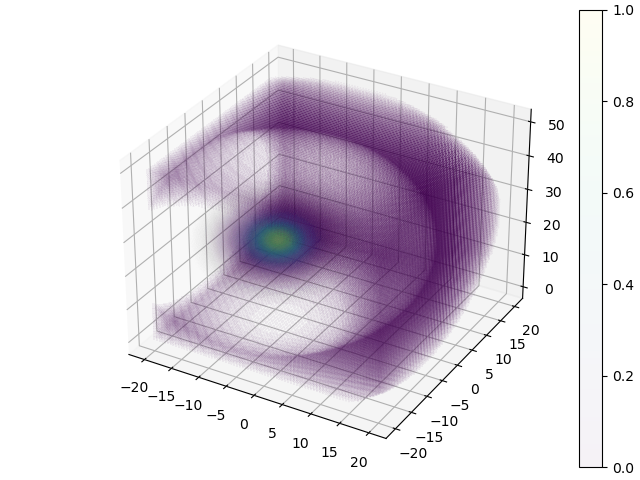

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mlp

cmap = plt.cm.viridis
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), constrained_layout=True)

x = [m.ravel() for m in mesh]
p1 = p0.ravel()

norm = mlp.colors.Normalize(vmin=p1.min(), vmax=p1.max())
scat = ax.scatter(*x, s=scale(p1)*5, c=norm(p1), cmap='viridis', alpha=0.05)
plt.colorbar(scat)

In [22]:
# storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(field, 0.5, dt=1e-3)  # solve the PDE

  0%|          | 0/0.5 [00:00<?, ?it/s]

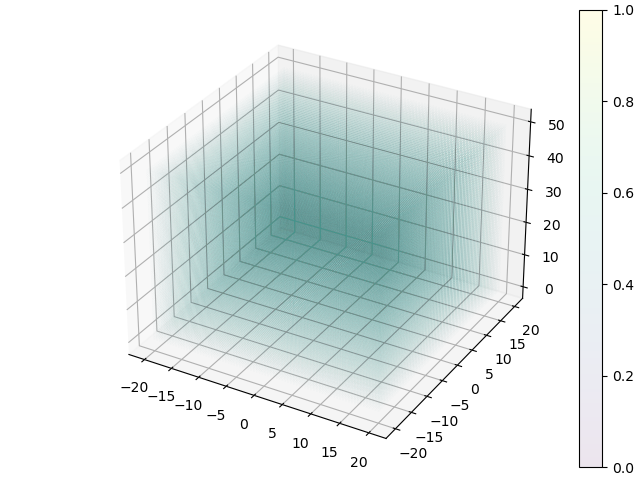

In [26]:
cmap = plt.cm.viridis
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), constrained_layout=True)

x = [m.ravel() for m in mesh]
p = res.data.ravel()

norm = mlp.colors.Normalize(vmin=p.min(), vmax=p.max())
scat = ax.scatter(*x, s=scale(p)*0.01, c=norm(p), cmap='viridis', alpha=0.1)
plt.colorbar(scat)

In [24]:
p.max(), p.min()

(2.5727023243649747e+158, -2.7025975551008363e+158)